In [159]:

from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from transformers import CLIPProcessor, CLIPModel
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
from utilities import *
import matplotlib.pyplot as plt
from u_net import Unet
from PIL import Image, ImageOps 


In [160]:

class DiceLoss(nn.Module):
    def __init__(self, device):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-5  
        self.device = device
        
    def forward(self, predict, target):
        predict = predict.to(self.device)
        target = target.to(self.device)

        intersection = torch.sum(predict * target, dim=(1, 2))  
        union = torch.sum(predict, dim=(1, 2)) + torch.sum(target, dim=(1, 2))

        dice = (2 * intersection + self.smooth) / (union + self.smooth)
        dice_loss = 1 - torch.mean(dice) 
            
        return dice_loss


In [161]:
#device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')
device = torch.device('cpu')
timesteps = 10
beta1 = 1e-4
beta2 = 0.02
n_feat = 128
n_cfeat = 512
height = 256
save_dir = '/Users/chenyufeng/desktop/smartBrush/checkpoint'
batch_size = 100
n_epoch = 32
lrate=1e-2
text='girl'

b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp()    
ab_t[0] = 1


processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True)
with torch.no_grad():
    text_embeddings = model.get_text_features(**inputs).squeeze(0).to(device) 

In [162]:
model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=512, height=height).to(device)


checkpoint_path = '/Users/chenyufeng/desktop/smartBrush/checkpoint/model_epoch_10.pth'  
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict']) 
    print(f'Checkpoint loaded from {checkpoint_path}')
else:
    print(f'No checkpoint found at {checkpoint_path}, starting from scratch')


Checkpoint loaded from /Users/chenyufeng/desktop/smartBrush/checkpoint/model_epoch_10.pth


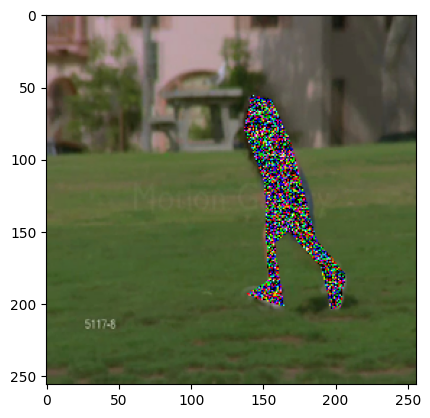

tensor(0.0395)tep   1


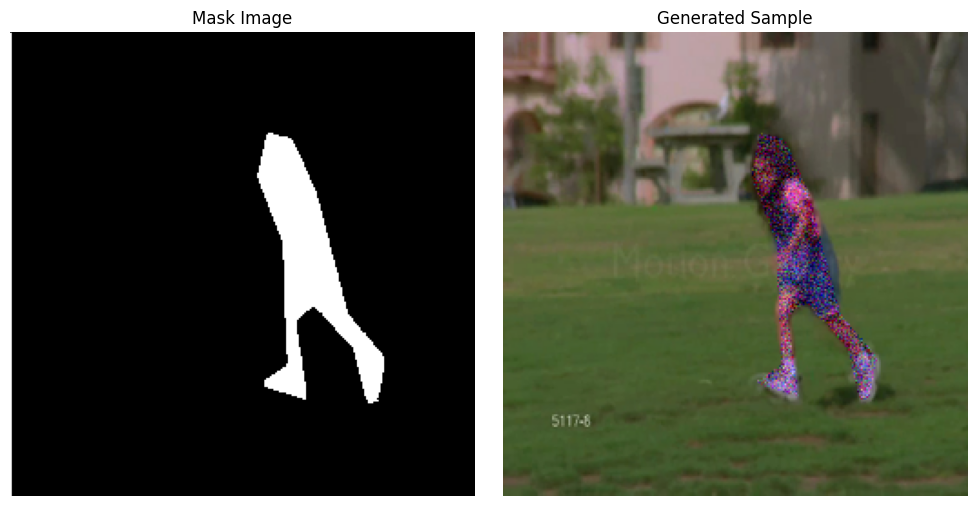

In [163]:
def denoise_add_noise(x,  t, pred_noise, z=None):
    if z is None:
        z = torch.randn_like(x)
    noise = b_t.sqrt()[t] * z
    mean = (x - pred_noise * ((1 - a_t[t]) / (1 - ab_t[t]).sqrt())) / a_t[t].sqrt()
    return mean + noise


@torch.no_grad()
def sample_ddpm(x0, mask): 
    samples = x0.clone()
    noise = torch.randn_like(samples) 
    mask_background = (mask>0.5).float()
    samples = noise * mask_background + samples * (1 - mask_background)
    
    samples_numpy = samples.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
    samples_numpy = np.clip(samples_numpy, 0,1)
    samples_image = Image.fromarray((samples_numpy * 255).astype(np.uint8))
    samples_image_resized = samples_image.resize((256, 256), Image.LANCZOS)

    plt.imshow(samples_image_resized)
    plt.show()


    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')
        t = torch.tensor([i / timesteps])[:, None, None, None].to(device)
        z = torch.randn_like(samples) if i > 1 else 0

        noise_pred, mask_pred = model(x=samples, t=t, c=text_embeddings, mask=mask)
        mask_pred = torch.sigmoid(mask_pred).float()
        mask_pred_background  = (mask_pred>0.5).float()

        #print(mse_loss(noise_pred*mask_pred_background,samples*mask_pred_background))

        samples = denoise_add_noise(samples*mask_pred_background, i, noise_pred*mask_pred_background, z)

        samples = samples*mask_pred_background + x0 * (1 - mask_pred_background)
    

    return samples, mask_pred_background


diss_loss = DiceLoss(device=device)
mse_loss = nn.MSELoss()
x0_path = '/Users/chenyufeng/desktop/2.png'
mask_s_path = '/Users/chenyufeng/desktop/3.png' 

ground_truth = '/Users/chenyufeng/desktop/1.png'

mask_s_image = Image.open(mask_s_path).resize((256, 256))
original_image = Image.open(x0_path).resize((256, 256))
ground_truth_image = Image.open(ground_truth).resize((256, 256))
to_gray = transforms.Grayscale(num_output_channels=1)

#mask_s_image = to_gray(mask_s_image)
mask_s_array = np.array(mask_s_image).astype(np.float32) / 255.0  

ground_truth = to_gray(ground_truth_image)
ground_truth_array = np.array(ground_truth).astype(np.float32) / 255.0 

original_array = np.array(original_image).astype(np.float32) / 255.0  

x0 = torch.tensor(original_array, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  
mask = torch.tensor(mask_s_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
ground_truth = torch.tensor(ground_truth_array, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

#gt and mask is tensor between 0 and 1 with a lot of float point

#mask = (torch.sigmoid(mask)>0.5).float()

#ground_truth = (torch.sigmoid(ground_truth)>0.5).float()


model.eval()
plt.clf()

samples, mask= sample_ddpm(x0=x0,mask=mask)

ground_truth = (ground_truth>0.5).float()
d_loss = diss_loss(mask, ground_truth)
print(d_loss)


mask_numpy = mask.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
samples_numpy = samples.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
samples_numpy = np.clip(samples_numpy, 0, 1)
mask_numpy = np.clip(mask_numpy, 0, 1)

mask_numpy_bw = mask_numpy.squeeze(-1) if mask_numpy.ndim > 2 else mask_numpy

mask_image_bw = Image.fromarray((mask_numpy_bw * 255).astype(np.uint8), mode="L")
samples_image = Image.fromarray((samples_numpy * 255).astype(np.uint8))

mask_image_resized = mask_image_bw.resize((256, 256), Image.LANCZOS)
samples_image_resized = samples_image.resize((256, 256), Image.LANCZOS)


fig, axes = plt.subplots(1, 2, figsize=(10, 5))


axes[0].imshow(mask_image_resized, cmap="gray")
axes[0].set_title("Mask Image")
axes[0].axis("off")  

axes[1].imshow(samples_image_resized)
axes[1].set_title("Generated Sample")
axes[1].axis("off") 

plt.tight_layout() 
plt.show()

In [135]:
ground_truth_numpy = ground_truth.cpu().numpy() 

ground_truth_numpy = ground_truth_numpy.squeeze()  

ground_truth_numpy = ground_truth_numpy.astype(np.int8)

different_pixels = np.sum(ground_truth_numpy != mask_image_resized)
same_pixels = np.sum(ground_truth_numpy == mask_image_resized)
print(f"different: {different_pixels}")

print(f"same: {same_pixels}")

different: 4128
same: 61408
